# Unsupervised neural computation - Practical

Dependencies:
- Python (>= 2.6 or >= 3.3)
- NumPy (>= 1.6.1)
- SciPy (>= 0.12)
- SciKit Learn (>=0.18.1)

Just as there are different ways in which we ourselves learn from our own surrounding environments, so it is with neural networks. In a broad sense, we may categorize the learning processes through which neural networks function as follows: learning with a teacher and learning without a teacher. 

These different forms of learning as performed on neural networks parallel those of human learning. Learning with a teacher is also referred to as supervised learning. In conceptual terms, we may think of the teacher as having knowledge of the environment, with that knowledge being represented by a set of input - output examples. Unsupervised learning does not require target vectors for the outputs. 

Without input-output training pairs as external teachers, unsupervised learning is self-organized to produce consistent output vectors by modifying weights. That is to say, there are no labelled examples of the function to be learned by the network. 

For a specific task-independent measure, once the network has become tuned to the statistical regularities of the input data, the network develops the ability to discover internal structure for encoding features of the input or compress the input data, and thereby to create new classes automatically.

## Radial Basis Functions and Radial Basis Function Networks - Semi-supervised Learning

### combining supervised and unsupervised learning

In machine learning, the radial basis function kernel, or RBF kernel, is a popular kernel function (typically Gaussian) used in various kernelized learning algorithms.

In [1]:
# Class implementing the basic RBF parametrization
# based on code from https://github.com/jeffheaton/aifh
import numpy as np

class RbfFunction(object):
    def __init__(self, dimensions, params, index):
        self.dimensions = dimensions
        self.params = params
        self.index = index

    @property
    def width(self):
        return self.params[self.index]

    @width.setter
    def width(self, value):
        self.params[self.index] = value

    def set_center(self, index, value):
        self.params[self.index + index + 1] = value

    def get_center(self, index):
        return self.params[self.index + index + 1]

RBFs can take various shapes: quadratic, multi-quadratic, inverse multi-quadratic, mexican hat. Yet the most used is the Gaussian.

In [2]:
# Class implementing a Gaussian RBF
class RbfGaussian(RbfFunction):
    def evaluate(self, x):
        value = 0
        width = self.width

        for i in range(self.dimensions):
            center = self.get_center(i)
            value += ((x[i] - center) ** 2) / (2.0 * width * width)
        return np.exp(-value)

A RBF network is an advanced machine learning algorithm that uses a series of RBF functions to perform regression.  It can also perform classification by means of one-of-n encoding. The long term memory of a RBF network is made up of the widths and centers of the RBF functions, as well as input and output weighting.

In [3]:
# Class implementing a Gaussian RBF Network
class RbfNetwork(object):

    def __init__(self, input_count, rbf_count, output_count):
        """ Create an RBF network with the specified shape.
        @param input_count: The input count.
        @param rbf_count: The RBF function count.
        @param output_count:  The output count.
        """
        self.input_count = input_count
        self.output_count = output_count

        # calculate input and output weight counts
        # add 1 to output to account for an extra bias node
        input_weight_count = input_count * rbf_count
        output_weight_count = (rbf_count + 1) * output_count
        rbf_params = (input_count + 1) * rbf_count
        self.long_term_memory = np.zeros((input_weight_count + output_weight_count + rbf_params), dtype=float)

        self.index_input_weights = 0
        self.index_output_weights = input_weight_count + rbf_params

        self.rbf = {}

        # default the Rbf's to gaussian
        for i in range(0, rbf_count):
            rbf_index = input_weight_count + ((input_count + 1) * i)
            self.rbf[i] = RbfGaussian(input_count, self.long_term_memory, rbf_index)


    def compute_regression(self, input):
        """ Compute the output for the network.
        @param input: The input pattern.
        @return: The output pattern.
        """
        # first, compute the output values of each of the RBFs
        # Add in one additional RBF output for bias (always set to one).
        rbf_output = [0] * (len(self.rbf) + 1)
        # bias
        rbf_output[len(rbf_output) - 1] = 1.0

        for rbfIndex in range(0, len(self.rbf)):
            # weight the input
            weighted_input = [0] * len(input)

            for inputIndex in range(0, len(input)):
                memory_index = self.index_input_weights + (rbfIndex * self.input_count) + inputIndex
                weighted_input[inputIndex] = input[inputIndex] * self.long_term_memory[memory_index]

            # calculate the rbf
            rbf_output[rbfIndex] = self.rbf[rbfIndex].evaluate(weighted_input)

        # Second, calculate the output, which is the result of the weighted result of the RBF's.
        result = [0] * self.output_count

        for outputIndex in range(0, len(result)):
            sum_value = 0
            for rbfIndex in range(0, len(rbf_output)):
                # add 1 to rbf length for bias
                memory_index = self.index_output_weights + (outputIndex * (len(self.rbf) + 1)) + rbfIndex
                sum_value += rbf_output[rbfIndex] * self.long_term_memory[memory_index]
            result[outputIndex] = sum_value

        # finally, return the result.
        return result

    def reset(self):
        """
        Reset the network to a random state.
        """
        for i in range(0, len(self.long_term_memory)):
            self.long_term_memory[i] = np.random.uniform(0, 1)

    def compute_classification(self, input):
        """ Compute the output and return the index of the output with the largest value.  This is the class that
        the network recognized.
        @param input: The input pattern.
        @return:
        """
        output = self.compute_regression(input)
        return output.index(max(output))

    def copy_memory(self, source):
        """ Copy the specified vector into the long term memory of the network.
        @param source: The source vector.
        """
        for i in range(0, len(source)):
            self.long_term_memory[i] = source[i]

The Iris dataset is a traditional benchmark in classification problems in ML. The data set consists of 50 samples from each of three species of Iris (Iris setosa, Iris virginica and Iris versicolor). Four features were measured from each sample: the length and the width of the sepals and petals, in centimetres. Based on the combination of these four features, Fisher developed a linear discriminant model to distinguish the species from each other.

The Iris flower data set or Fisher's Iris data set is a multivariate data set introduced by Ronald Fisher in his 1936 paper "The use of multiple measurements in taxonomic problems" as an example of linear discriminant analysis. It is sometimes called Anderson's Iris data set because Edgar Anderson collected the data to quantify the morphologic variation of Iris flowers of three related species. Based on Fisher's linear discriminant model, this data set became a typical test case for many statistical classification techniques in machine learning such as support vector machines.

In the following we will use simulated annealing to fit an RBF network to the Iris data set, to classifiy the iris species correctly.

Simulated annealing is a probabilistic technique for approximating the global optimum of a given function. Specifically, it is a metaheuristic to approximate global optimization in a large search space.

In [4]:
# Find the dataset
import os
import sys
from normalize import Normalize
from error import ErrorCalculation
from train import TrainAnneal
import numpy as np

irisFile = os.path.abspath("./data/iris.csv")

# Read the Iris data set
print('Reading CSV file: ' + irisFile)
norm = Normalize()
iris_work = norm.load_csv(irisFile)

# Extract the original iris species so we can display during the final validation
ideal_species = [row[4] for row in iris_work]

# Setup the first four fields to "range normalize" between -1 and 1.
for i in range(0, 4):
    norm.make_col_numeric(iris_work, i)
    norm.norm_col_range(iris_work, i, 0, 1)

# Discover all of the classes for column #4, the iris species.
classes = norm.build_class_map(iris_work, 4)
inv_classes = {v: k for k, v in classes.items()}

# Normalize iris species using one-of-n.
# We could have used equilateral as well.  For an example of equilateral, see the example_nm_iris example.
norm.norm_col_one_of_n(iris_work, 4, classes, 0, 1)

# Prepare training data.  Separate into input and ideal.
training = np.array(iris_work)
training_input = training[:, 0:4]
training_ideal = training[:, 4:7]

Reading CSV file: /media/data_warehouse/Dropbox/Public/sandbox/teaching/Basecamp.ai_Lectures/code/data/iris.csv


In [5]:
# Define the score of the training process of the network
def score_funct(x):
    """
    The score function for Iris anneal.
    @param x:
    @return:
    """
    global best_score
    global input_data
    global output_data
    # Update the network's long term memory to the vector we need to score.
    network.copy_memory(x)
    # Loop over the training set and calculate the output for each.
    actual_output = []
    for input_data in training_input:
        output_data = network.compute_regression(input_data)
        actual_output.append(output_data)
    # Calculate the error with MSE.
    result = ErrorCalculation.mse(np.array(actual_output), training_ideal)
    return result

In [31]:
# Create an RBF network.  There are four inputs and two outputs.
# There are also five RBF functions used internally.
# You can experiment with different numbers of internal RBF functions.
# However, the input and output must match the data set.
inputs = 4
rbfs = 4
outputs = 3
network = RbfNetwork(inputs, rbfs, outputs)
network.reset()

# Create a copy of the long-term memory.  This becomes the initial state.
x0 = list(network.long_term_memory)

# Perform the annealing

#         Train a Machine Learning Algorithm using Simulated Annealing.  Simulated Annealing is a Monte Carlo algorithm
#         that is based on annealing in metallurgy, a technique involving heating and controlled cooling of a
#         material to increase the size of its crystals and reduce their defects, both are attributes of the material
#         that depend on its thermodynamic free energy.
        
train = TrainAnneal()
train.display_iteration = True
train.train(x0, score_funct)

# Display the final validation.  We show all of the iris data as well as the predicted species.
for i in range(0, len(training_input)):
    input_data = training_input[i]
    # Compute the output from the RBF network
    output_data = network.compute_regression(input_data)
    ideal_data = training_ideal[i]
    # Decode the three output neurons into a class number.
    class_id = norm.denorm_one_of_n(output_data)
    print(str(input_data) + " -> " + inv_classes[class_id] + ", Ideal: " + ideal_species[i])

It is often used when the search space is discrete (e.g., all tours that visit a given set of cities). For problems where finding an approximate global optimum is more important than finding a precise local optimum in a fixed amount of time, simulated annealing may be preferable to alternatives such as gradient descent.

## Assignments

Given the RBFN API please follow the next steps to train a RBF to clssify the Iris dataset.

In [7]:
# Perform the simmulated annealing.
# Display the final validation.  We show all of the iris data as well as the predicted species.
# Compute the output from the RBF network
# Decode the three output neurons into a class number and print it 

# Vector Quantization

Vector quantization (VQ) is a form of competitive learning. Such an algorithm is able to discover structure in the input data. Generally speaking, vector quantization is a form of lossy data compression—lossy in the sense that some information contained in the input data is lost as a result of the compression.
![title](img/vq_alg.png)
An input data point belongs to a certain class if its position (in the 2D space) is closest to the class prototype, fulfilling the Voronoi partitioning (i.e. partitioning of a plane into regions based on distance to points in a specific subset of the plane.
![title](img/vq.png)
In a typical scenario, such behavior can be implemented with a neural network that consists of two layers—an input layer and a competitive layer with lateral inhibition. The input layer receives the available data. The competitive layer consists of neurons that compete with each other.
![title](img/vq_net.png)
The classic image processing example, Lena, an 8-bit grayscale bit-depth, 512 x 512 sized image, is used here to illustrate how `k`-means is used for vector quantization.

In [8]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import cluster
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version

try:
    face = sp.face(gray=True)
except AttributeError:
    # Newer versions of scipy have face in misc
    from scipy import misc
    face = misc.face(gray=True)

n_clusters = 5
np.random.seed(0)

X = face.reshape((-1, 1))  # We need an (n_sample, n_feature) array
k_means = cluster.KMeans(n_clusters=n_clusters, n_init=4)
k_means.fit(X)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

# create an array from labels and values
face_compressed = np.choose(labels, values)
face_compressed.shape = face.shape

vmin = face.min()
vmax = face.max()

Plot the results of the clutering and plot the original, quatized, and histogram.

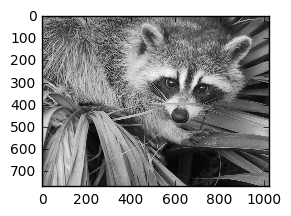

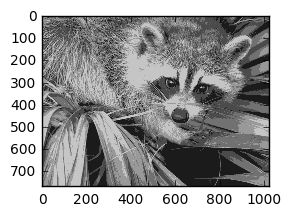

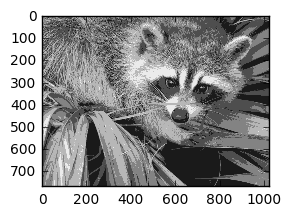

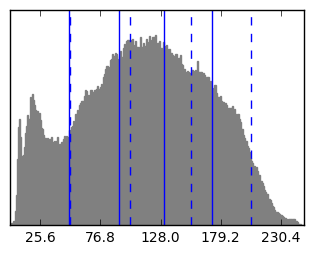

In [9]:
# original face
plt.figure(1, figsize=(3, 2.2))
plt.imshow(face, cmap=plt.cm.gray, vmin=vmin, vmax=256)

# compressed face
plt.figure(2, figsize=(3, 2.2))
plt.imshow(face_compressed, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

# equal bins face
regular_values = np.linspace(0, 256, n_clusters + 1)
regular_labels = np.searchsorted(regular_values, face) - 1
regular_values = .5 * (regular_values[1:] + regular_values[:-1])  # mean
regular_face = np.choose(regular_labels.ravel(), regular_values, mode="clip")
regular_face.shape = face.shape
plt.figure(3, figsize=(3, 2.2))
plt.imshow(regular_face, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

# histogram
plt.figure(4, figsize=(3, 2.2))
plt.clf()
plt.axes([.01, .01, .98, .98])
plt.hist(X, bins=256, color='.5', edgecolor='.5')
plt.yticks(())
plt.xticks(regular_values)
values = np.sort(values)
for center_1, center_2 in zip(values[:-1], values[1:]):
    plt.axvline(.5 * (center_1 + center_2), color='b')

for center_1, center_2 in zip(regular_values[:-1], regular_values[1:]):
    plt.axvline(.5 * (center_1 + center_2), color='b', linestyle='--')

plt.show()

## Assignments

In this problem you should group 2d input points (x,y) into clusters and determine the center of each cluster. The number of required clusters is provided as integer number on the first line. Following, the system provides an unknown number of 2d input data points (x, y), one per line. Continue reading until your program obtains no more data. You can safely assume to read less than 1000 points. After reading, you should run the Vector Quantization algorithm to find the center(s) of input data, and finally report the center position as x, y coordinate. Present one such center position per output line. The order of center points output does not matter.

3 cluster VQ
![title](img/vq_3clust.png)

In [10]:
# load the datasets for training and testing 
import numpy as np
import csv 
with open('./data/vq_3clust_in.txt') as inputfile:
    train_data = list(csv.reader(inputfile))
with open('./data/vq_3clust_out.txt') as inputfile:
    test_data = list(csv.reader(inputfile))
    
# add network code here

6 cluster VQ
![title](img/vq_3clust.png)

In [11]:
# load the datasets for training and testing for the 6 cluster example
import numpy as np
import csv 
with open('./data/vq_6clust_in.txt') as inputfile:
    train_data = list(csv.reader(inputfile))
with open('./data/vq_6clust_out.txt') as inputfile:
    test_data = list(csv.reader(inputfile))
    
# add network code here

# Self-Organizing Maps

In neurobiology, during neural growth, synapses are strengthened or weakened, in a process usually modelled as a competition for resources. In such a learning process, there is a competition between the neurons to fire. More precisely, neurons compete with each other (in accordance with a learning rule) for the “opportunity” to respond to features contained in the input data. 
![title](img/som.png)
In its simplest form, such behaviour describes a “winner-takes-all” strategy. In such a strategy, the neuron with the greatest total input “wins” the competition and turns on; all the other neurons in the network then switch off. The aim of such learning mechanisms is to cluster the data.
![title](img/som_tr.png)
Kohonen’s self-organizing map (SOM) is one of the most popular unsupervised neural network models. Developed for an associative memory model, it is an unsupervised learning algorithm with a simple structure and computational form, and is motivated by the retina-cortex mapping. The SOM can provide topologically preserved mapping from input to output spaces, such that “nearby” sensory stimuli are represented in “nearby” regions.
![title](img/som_alg.png)

In [27]:
# Class implementing a basic SOM
import scipy.spatial
import numpy as np
import scipy as sp
import sys


class SelfOrganizingMap:
    """
    The weights of the output neurons base on the input from the input
    neurons.
    """

    def __init__(self, input_count, output_count):
        """
        The constructor.
        :param input_count: Number of input neurons
        :param output_count: Number of output neurons
        :return:
        """
        self.input_count = input_count
        self.output_count = output_count
        self.weights = np.zeros([self.output_count, self.input_count])

        self.distance = sp.spatial.distance.euclidean

    def calculate_error(self, data):
        bmu = BestMatchingUnit(self)

        bmu.reset()

        # Determine the BMU for each training element.
        for input in data:
            bmu.calculate_bmu(input)

        # update the error
        return bmu.worst_distance / 100.0

    def classify(self, input):
        if len(input) > self.input_count:
            raise Exception("Can't classify SOM with input size of {} "
                            "with input data of count {}".format(self.input_count, len(input)))

        min_dist = sys.maxfloat
        result = -1

        for i in range(self.output_count):
            dist = self.distance.calculate(input, self.weights[i])
            if dist < min_dist:
                min_dist = dist
                result = i

        return result

    def reset(self):
        self.weights = (np.random.rand(self.weights.shape[0], self.weights.shape[1]) * 2.0) - 1

The "Best Matching Unit" or BMU is a very important concept in the training for a SOM. The BMU is the output neuron that has weight connections to the input neurons that most closely match the current input vector. This neuron (and its "neighborhood") are the neurons that will receive training.

In [28]:
# Class implementing the competition stage in SOM, finding the best matching unit.
class BestMatchingUnit:
    """
    This class also tracks the worst distance (of all BMU's). This gives some
    indication of how well the network is trained, and thus becomes the "error"
    of the entire network.
    """

    def __init__(self, som):
        """
        Construct a BestMatchingUnit class.  The training class must be provided.
        :param som: The SOM to evaluate.
        """
        # The owner of this class.
        self.som = som

        # What is the worst BMU distance so far, this becomes the error for the
        # entire SOM.
        self.worst_distance = 0

    def calculate_bmu(self, input):
        """
        Calculate the best matching unit (BMU). This is the output neuron that
        has the lowest Euclidean distance to the input vector.
        :param input: The input vector.
        :return: The output neuron number that is the BMU.
        """
        result = 0

        if len(input) > self.som.input_count:
            raise Exception(
                "Can't train SOM with input size of {}  with input data of count {}.".format(self.som.input_count,
                                                                                             len(input)))

        # Track the lowest distance so far.
        lowest_distance = float("inf")

        for i in range(self.som.output_count):
            distance = self.calculate_euclidean_distance(self.som.weights, input, i)

            # Track the lowest distance, this is the BMU.
            if distance < lowest_distance:
                lowest_distance = distance
                result = i

        # Track the worst distance, this is the error for the entire network.
        if lowest_distance > self.worst_distance:
            self.worst_distance = lowest_distance

        return result

    def calculate_euclidean_distance(self, matrix, input, output_neuron):
        """
        Calculate the Euclidean distance for the specified output neuron and the
        input vector.  This is the square root of the squares of the differences
        between the weight and input vectors.
        :param matrix: The matrix to get the weights from.
        :param input: The input vector.
        :param outputNeuron: The neuron we are calculating the distance for.
        :return: The Euclidean distance.
        """
        result = 0

        # Loop over all input data.
        diff = input - matrix[output_neuron]
        return np.sqrt(sum(diff*diff))

In the next section we analyze competitive training, which would be used in a winner-take-all neural network, such as the self organizing map (SOM). This is an unsupervised training method, no ideal data is needed on the training set. If ideal data is provided, it will be ignored. Training is done by looping over all of the training elements and calculating a "best matching unit" (BMU). This BMU output neuron is then adjusted to better "learn" this pattern. Additionally, this training may be applied to other "nearby" output neurons. The degree to which nearby neurons are update is defined by the neighborhood function.

A neighborhood function is required to determine the degree to which neighboring neurons (to the winning neuron) are updated by each training iteration. Because this is unsupervised training, calculating an error to measure progress by is difficult. The error is defined to be the "worst", or longest, Euclidean distance of any of the BMU's. This value should be minimized, as learning progresses.

In [29]:
# Class implementing the basic training algorithm for a SOM
class BasicTrainSOM:
    """
    Because only the BMU neuron and its close neighbors are updated, you can end
    up with some output neurons that learn nothing. By default these neurons are
    not forced to win patterns that are not represented well. This spreads out
    the workload among all output neurons. This feature is not used by default,
    but can be enabled by setting the "forceWinner" property.
    """

    def __init__(self, network, learning_rate, training, neighborhood):

        # The neighborhood function to use to determine to what degree a neuron
        # should be "trained".
        self.neighborhood = neighborhood

        # The learning rate. To what degree should changes be applied.
        self.learning_rate = learning_rate

        # The network being trained.
        self.network = network

        # How many neurons in the input layer.
        self.input_neuron_count = network.input_count

        # How many neurons in the output layer.
        self.output_neuron_count = network.output_count

        # Utility class used to determine the BMU.
        self.bmu_util = BestMatchingUnit(network)

        # Correction matrix.
        self.correction_matrix = np.zeros([network.output_count, network.input_count])

        # True is a winner is to be forced, see class description, or forceWinners
        # method. By default, this is true.
        self.force_winner = False

        # When used with autodecay, this is the starting learning rate.
        self.start_rate = 0

        # When used with autodecay, this is the ending learning rate.
        self.end_rate = 0

        # When used with autodecay, this is the starting radius.
        self.start_radius = 0

        # When used with autodecay, this is the ending radius.
        self.end_radius = 0

        # This is the current autodecay learning rate.
        self.auto_decay_rate = 0

        # This is the current autodecay radius.
        self.auto_decay_radius = 0

        # The current radius.
        self.radius = 0

        # Training data.
        self.training = training

    def _apply_correction(self):
        """
        Loop over the synapses to be trained and apply any corrections that were
        determined by this training iteration.
        """
        np.copyto(self.network.weights, self.correction_matrix)

    def auto_decay(self):
        """
        Should be called each iteration if autodecay is desired.
        """
        if self.radius > self.end_radius:
            self.radius += self.auto_decay_radius

        if self.learning_rate > self.end_rate:
            self.learning_rate += self.auto_decay_rate

        self.neighborhood.radius = self.radius

    def copy_input_pattern(self, matrix, output_neuron, input):
        """
        Copy the specified input pattern to the weight matrix. This causes an
        output neuron to learn this pattern "exactly". This is useful when a
        winner is to be forced.
        :param matrix: The matrix that is the target of the copy.
        :param output_neuron: The output neuron to set.
        :param input: The input pattern to copy.
        """
        matrix[output_neuron, :] = input

    def decay(self, decay_rate, decay_radius):
        """
        Decay the learning rate and radius by the specified amount.
        :param decay_rate: The percent to decay the learning rate by.
        :param decay_radius: The percent to decay the radius by.
        """
        self.radius *= (1.0 - decay_radius)
        self.learning_rate *= (1.0 - decay_rate)
        self.neighborhood.radius = self.radius

    def _determine_new_weight(self, weight, input, currentNeuron, bmu):
        """
        Determine the weight adjustment for a single neuron during a training
        iteration.
        :param weight: The starting weight.
        :param input: The input to this neuron.
        :param currentNeuron: The neuron who's weight is being updated.
        :param bmu: The neuron that "won", the best matching unit.
        :return: The new weight value.
        """
        return weight \
               + (self.neighborhood.fn(currentNeuron, bmu) \
                  * self.learning_rate * (input - weight))

    def _force_winners(self, matrix, won, least_represented):
        """
        Force any neurons that did not win to off-load patterns from overworked
        neurons.
        :param matrix: An array that specifies how many times each output neuron has "won".
        :param won: The training pattern that is the least represented by this neural network.
        :param least_represented: The synapse to modify.
        :return: True if a winner was forced.
        """
        max_activation = float("-inf")
        max_activation_neuron = -1

        output = self.compute(self.network, self.least_represented)

        # Loop over all of the output neurons. Consider any neurons that were
        # not the BMU (winner) for any pattern. Track which of these
        # non-winning neurons had the highest activation.
        for output_neuron in range(len(won)):
            # Only consider neurons that did not "win".
            if won[output_neuron] == 0:
                if (max_activation_neuron == -1) \
                        or (output[output_neuron] > max_activation):
                    max_activation = output[output_neuron]
                    max_activation_neuron = output_neuron

        # If a neurons was found that did not activate for any patterns, then
        # force it to "win" the least represented pattern.
        if max_activation_neuron != -1:
            self.copy_input_pattern(matrix, max_activation_neuron, least_represented)
            return True
        else:
            return False

    def iteration(self):
        """
        Perform one training iteration.
        """
        # Reset the BMU and begin this iteration.
        self.bmu_util.reset()
        won = [0] * self.output_neuron_count
        least_represented_activation = float("inf")
        least_represented = None

        # Reset the correction matrix for this synapse and iteration.
        self.correctionMatrix.clear()

        # Determine the BMU for each training element.
        for input in self.training:
            bmu = self.bmu_util.calculate_bmu(input)
            won[bmu] += 1

            # If we are to force a winner each time, then track how many
            # times each output neuron becomes the BMU (winner).
            if self.force_winner:
                # Get the "output" from the network for this pattern. This
                # gets the activation level of the BMU.
                output = self.compute(self.network, input)

                # Track which training entry produces the least BMU. This
                # pattern is the least represented by the network.
                if output[bmu] < least_represented_activation:
                    least_represented_activation = output[bmu]
                    least_represented = input.getInput()

            self.train(bmu, self.network.getWeights(), input.getInput())

            if self.force_winner:
                # force any non-winning neurons to share the burden somewhat
                if not self.force_winners(self.network.weights, won, least_represented):
                    self.apply_correction()
            else:
                self.apply_correction()

    def set_auto_decay(self, planned_iterations, start_rate, end_rate, start_radius, end_radius):
        """
        Setup autodecay. This will decrease the radius and learning rate from the
        start values to the end values.
        :param planned_iterations: The number of iterations that are planned. This allows the
        decay rate to be determined.
        :param start_rate: The starting learning rate.
        :param end_rate: The ending learning rate.
        :param start_radius: The starting radius.
        :param end_radius: The ending radius.
        """
        self.start_rate = start_rate
        self.end_rate = end_rate
        self.start_radius = start_radius
        self.end_radius = end_radius
        self.auto_decay_radius = (end_radius - start_radius) / planned_iterations
        self.auto_decay_rate = (end_rate - start_rate) / planned_iterations
        self.set_params(self.start_rate, self.start_radius)

    def set_params(self, rate, radius):
        """
        Set the learning rate and radius.
        :param rate: The new learning rate.
        :param radius:
        :return: The new radius.
        """
        self.radius = radius
        self.learning_rate = rate
        self.neighborhood.radius = radius

    def get_status(self):
        """
        :return: A string display of the status.
        """
        result = "Rate="
        result += str(self.learning_rate)
        result += ", Radius="
        result += str(self.radius)
        return result

    def _train(self, bmu, matrix, input):
        """
        Train for the specified synapse and BMU.
        :param bmu: The best matching unit for this input.
        :param matrix: The synapse to train.
        :param input: The input to train for.
        :return:
        """
        # adjust the weight for the BMU and its neighborhood
        for output_neuron in range(self.output_neuron_count):
            self._train_pattern(matrix, input, output_neuron, bmu)

    def _train_pattern(self, matrix, input, current, bmu):
        """
        Train for the specified pattern.
        :param matrix: The synapse to train.
        :param input: The input pattern to train for.
        :param current: The current output neuron being trained.
        :param bmu: The best matching unit, or winning output neuron.
        """

        for input_neuron in range(self.input_neuron_count):
            current_weight = matrix[current][input_neuron]
            input_value = input[input_neuron]

            new_weight = self._determine_new_weight(current_weight,
                    input_value, current, bmu)

            self.correction_matrix[current][input_neuron] = new_weight

    def train_single_pattern(self, pattern):
        """
        Train the specified pattern. Find a winning neuron and adjust all neurons
        according to the neighborhood function.
        :param pattern: The pattern to train.
        """
        bmu = self.bmu_util.calculate_bmu(pattern)
        self._train(bmu, self.network.weights, pattern)
        self._apply_correction()

    def compute(self, som, input):
        """
        Calculate the output of the SOM, for each output neuron.  Typically,
        you will use the classify method instead of calling this method.
        :param som: The input pattern.
        :param input: The output activation of each output neuron.
        :return:
        """

        result = np.zeros(som.output_count)

        for i in range(som.output_count):
            optr = som.weights[i]

            matrix_a = np.zeros([input.length,1])
            for j in range(len(input)):
                matrix_a[0][j] = input[j]

            matrix_b = np.zeros(1,input.length)
            for j in range(len(optr)):
                matrix_b[0][j] = optr[j]

            result[i] = np.dot(matrix_a, matrix_b)

        return result

A common example used to help teach the principals behind SOMs is the mapping of colours from their three dimensional components - red, green and blue, into two dimensions.The colours are presented to the network as 3D vectors - one dimension for each of the colour components (RGB encoding) - and the network learns to represent them in the 2D space we can see. Notice that in addition to clustering the colours into distinct regions, regions of similar properties are usually found adjacent to each other.

In [30]:
import os
import sys
from Tkinter import *
import numpy as np
from neighborhood import *

TILES_WIDTH = 50
TILES_HEIGHT = 50
TILE_SCREEN_SIZE = 10

class DisplayColors:
    def __init__(self,root,samples):
        # Build the grid display
        canvas_width = TILES_WIDTH * TILE_SCREEN_SIZE
        canvas_height = TILES_HEIGHT * TILE_SCREEN_SIZE

        self.samples = samples
        self.root = root
        self.c = Canvas(self.root,width=canvas_width, height=canvas_height)
        self.c.pack()

        self.grid_rects = [[None for j in range(TILES_WIDTH)]
            for i in range(TILES_HEIGHT)]

        for row in range(TILES_HEIGHT):
            for col in range(TILES_WIDTH):
                x = col * TILE_SCREEN_SIZE
                y = row * TILE_SCREEN_SIZE
                r = self.c.create_rectangle(x, y, x+TILE_SCREEN_SIZE,y+TILE_SCREEN_SIZE, fill="white")
                self.grid_rects[row][col] = r

        self.som = SelfOrganizingMap(3,TILES_WIDTH * TILES_HEIGHT)
        self.som.reset()

        self.gaussian = NeighborhoodRBF(NeighborhoodRBF.TYPE_GAUSSIAN,[TILES_WIDTH,TILES_HEIGHT])
        self.train = BasicTrainSOM(self.som, 0.01, None, self.gaussian)
        self.train.force_winner = False
        self.train.set_auto_decay(1000, 0.8, 0.003, 30, 5)
        self.iteration = 1

    def RGBToHTMLColor(self, rgb_tuple):
        hexcolor = '#%02x%02x%02x' % rgb_tuple
        return hexcolor

    def convert_color(self, d):
        result = 128*d
        result+= 128
        result = min(result, 255)
        result = max(result, 0)
        return result

    def update(self, som):
        for row in range(TILES_HEIGHT):
            for col in range(TILES_WIDTH):
                index = (row*TILES_WIDTH)+col
                color = (
                    self.convert_color(som.weights[index][0]),
                    self.convert_color(som.weights[index][1]),
                    self.convert_color(som.weights[index][2]))
                r = self.grid_rects[row][col]
                self.c.itemconfig(r, fill=self.RGBToHTMLColor(color))
                self.c.itemconfig(r, outline=self.RGBToHTMLColor(color))

    def update_clock(self):
        idx = np.random.randint(len(samples))
        c = self.samples[idx]

        self.train.train_single_pattern(c)
        self.train.auto_decay()
        self.update(self.som)
        print("Iteration {}, {}".format(self.iteration,self.train.get_status()))
        self.iteration+=1
        if self.iteration<=1000:
            self.root.after(1, self.update_clock)




samples = np.zeros([15,3])
for i in range(15):
    samples[i][0] = np.random.uniform(-1,1)
    samples[i][1] = np.random.uniform(-1,1)
    samples[i][2] = np.random.uniform(-1,1)

root = Tk()
display = DisplayColors(root, samples)
display.update_clock()
root.mainloop()

Iteration 1, Rate=0.799203, Radius=29
Iteration 2, Rate=0.798406, Radius=28
Iteration 3, Rate=0.797609, Radius=27
Iteration 4, Rate=0.796812, Radius=26
Iteration 5, Rate=0.796015, Radius=25
Iteration 6, Rate=0.795218, Radius=24
Iteration 7, Rate=0.794421, Radius=23
Iteration 8, Rate=0.793624, Radius=22
Iteration 9, Rate=0.792827, Radius=21
Iteration 10, Rate=0.79203, Radius=20
Iteration 11, Rate=0.791233, Radius=19
Iteration 12, Rate=0.790436, Radius=18
Iteration 13, Rate=0.789639, Radius=17
Iteration 14, Rate=0.788842, Radius=16
Iteration 15, Rate=0.788045, Radius=15
Iteration 16, Rate=0.787248, Radius=14
Iteration 17, Rate=0.786451, Radius=13
Iteration 18, Rate=0.785654, Radius=12
Iteration 19, Rate=0.784857, Radius=11
Iteration 20, Rate=0.78406, Radius=10
Iteration 21, Rate=0.783263, Radius=9
Iteration 22, Rate=0.782466, Radius=8
Iteration 23, Rate=0.781669, Radius=7
Iteration 24, Rate=0.780872, Radius=6
Iteration 25, Rate=0.780075, Radius=5
Iteration 26, Rate=0.779278, Radius=5
Ite

# Asignments

In this assignment a solution path for the Traveling Salesman Problem (finding a short path to travel once to each city and return home), for an unknown number of cities as input (you can safely assume <= 1000 cities). Each city consists of an ID (an integer number), and X and Y position of that city (two integer numbers). The provided input format for each line to read in is CITY-ID,X,Y\n.

Your program shall implement a Self-Organizing Map to accomplish this task. When your SOM finished learning, print the path as one city-id per line, followed by '\n'. Example for three cities with IDs 1,2,3 which are visited in the order 3,1,2:

  3\n
  1\n
  2\n

Remember that the number of cities in the output corresponds exactly to the number of cities in the input. It does not matter which of the cities is the first on your path.
You can safely assume that your program does not need to find the shortest possible path (remember, this problem is NP hard!), but your result needs to be within 15% of the shortest path we found (which again might not be optimal).

A travelling salesmap across Europe :)
![title](img/som_ts_eu.png)

In [16]:
# load the datasets for training and testing for TS in Europe
import numpy as np
import csv 
with open('./data/som_ts_in.txt') as inputfile:
    train_data = list(csv.reader(inputfile))
with open('./data/som_ts_out.txt') as inputfile:
    test_data = list(csv.reader(inputfile))
    
# add network code here

And for a more complex example, consider a more restricted dataset.
![title](img/som_ts_random.png)

In [17]:
# load the datasets for training and testing for TS 
import numpy as np
import csv 
with open('./data/som_ts_in_aux.txt') as inputfile:
    train_data = list(csv.reader(inputfile))
with open('./data/som_ts_out_aux.txt') as inputfile:
    test_data = list(csv.reader(inputfile))
    
# add network code here

# Hopfield Networks

Donald Hebb hypothesized in 1949 how neurons are connected with each other in the brain: “When an axon of cell A is near enough to excite a cell B and repeatedly or persistently takes part in firing it, some growth process or metabolic change takes place in one or both cells such that A’s efficiency, as one of the cells firing B, is increased.”, and postulated a new learning mechanism, Hebbian learning. 

In other words neural networks stores and retrieves associations, which are learned as synaptic connection. In Hebbian learning, both presynaptic and postsynaptic neurons are involved. Human memory thus works in an associative or content-addressable way.

The model is a recurrent neural network with fully interconnected neurons. The number of feedback loops is equal to the number of neurons. Basically, the output of each neuron is fed back, via a unit-time delay element, to each of the other neurons in the network. 
![title](img/hopfield.png)
Such a structure allows the network to recognise any of the learned patterns by exposure to only partial or even some corrupted information about that pattern, i.e., it eventually settles down and returns the closest pattern or the best guess.

In [18]:
# Class implementing a Hopfield Network
import numpy as np
from energetic import EnergeticNetwork

class HopfieldNetwork(EnergeticNetwork):
    def __init__(self, neuron_count):
        EnergeticNetwork.__init__(self, neuron_count)
        self.input_count = neuron_count
        self.output_count = neuron_count
        self.activation_function = lambda d: 1 if (d > 0) else 0

    def compute(self, input):
        """
        Note: for Hopfield networks, you will usually want to call the "run"
        method to compute the output.
        This method can be used to copy the input data to the current state. A
        single iteration is then run, and the new current state is returned.
        :param input: The input pattern.
        :return: The new current state.
        """
        result = self.current_state[:]
        self.run()

        for i in range(self.current_state):
            result[i] = self.activation_function(self.current_state[i])

        self.current_state[:] = result
        return result

    def run(self):
        """
        Perform one Hopfield iteration.
        """
        for to_neuron in range(self.neuron_count):
            sum = 0
            for from_neuron in range(self.neuron_count):
                sum += self.current_state[from_neuron] \
                    * self.get_weight(from_neuron, to_neuron)
                self.current_state[to_neuron] = self.activation_function(sum)

    def run_until_stable(self, max_cycle):
        """
        Run the network until it becomes stable and does not change from more runs.
        :param max_cycle: The maximum number of cycles to run before giving up.
        :return: The number of cycles that were run.
        """

        done = False
        last_state_str = str(self.current_state)
        current_state_str = last_state_str

        cycle = 0
        while not done:
            self.run()
            cycle += 1

            last_state_str = str(self.current_state)

            if last_state_str == current_state_str:
                if cycle > max_cycle:
                    done = True
            else:
                done = True

            current_state_str = last_state_str

        return cycle

    def energy(self):
        t = 0

        # Calculate first term
        a = 0
        for i in range(self.input_count):
            for j in range(self.output_count):
                a += self.get_weight(i, j) * self.current_state[i] * self.current_state[j]
        a *= -0.5

        # Calculate second term
        b = 0
        for i in range(self.input_count):
            b += self.current_state[i] * t
        return a+b

In the next section we implement the Hopefield Network training algorithm
![title](img/hopfield_alg.png)

In [19]:
class TrainHopfieldHebbian:
    def __init__(self, network):
        self.network = network;
        self.sum_matrix = np.zeros([network.input_count, network.input_count])
        self.pattern_count = 1

    def add_pattern(self, pattern):
        for i in range(self.network.input_count):
            for j in range(self.network.input_count):
                if i == j:
                    self.sum_matrix[i][j] = 0
                else:
                    self.sum_matrix[i][j] += pattern[i] * pattern[j]

        self.pattern_count += 1

    def learn(self):
        if self.pattern_count == 0:
            raise Exception("Please add a pattern before learning.  Nothing to learn.")

        for i in range(self.network.input_count):
            for j in range(self.network.input_count):
                self.network.set_weight(i, j, self.sum_matrix[i][j]/self.pattern_count)

In the following sample problem we will implement a Hopfield network to correct distorted patterns (here: 2D images). The algorithm reads a collection of binary images (5 patterns), each image being 10x10 "pixels" in size. A pixel may either be a space ' ' or a circle 'o'. 

We will train a Hopfield network (size 10x10 neurons) with these images as attractors. After training, the algorithm will read another small number of images with "distortions"; i.e. with incorrect pixel patterns compared to the previously trained images. For each such "distorted" image the algorithm shall output the closest training example.

In [20]:
# The neural network will learn these patterns.
PATTERN =  [[
            "O O O O O ",
            " O O O O O",
            "O O O O O ",
            " O O O O O",
            "O O O O O ",
            " O O O O O",
            "O O O O O ",
            " O O O O O",
            "O O O O O ",
            " O O O O O"],

          [ "OO  OO  OO",
            "OO  OO  OO",
            "  OO  OO  ",
            "  OO  OO  ",
            "OO  OO  OO",
            "OO  OO  OO",
            "  OO  OO  ",
            "  OO  OO  ",
            "OO  OO  OO",
            "OO  OO  OO"  ],

          [ "OOOOO     ",
            "OOOOO     ",
            "OOOOO     ",
            "OOOOO     ",
            "OOOOO     ",
            "     OOOOO",
            "     OOOOO",
            "     OOOOO",
            "     OOOOO",
            "     OOOOO"  ],

          [ "O  O  O  O",
            " O  O  O  ",
            "  O  O  O ",
            "O  O  O  O",
            " O  O  O  ",
            "  O  O  O ",
            "O  O  O  O",
            " O  O  O  ",
            "  O  O  O ",
            "O  O  O  O"  ],

          [ "OOOOOOOOOO",
            "O        O",
            "O OOOOOO O",
            "O O    O O",
            "O O OO O O",
            "O O OO O O",
            "O O    O O",
            "O OOOOOO O",
            "O        O",
            "OOOOOOOOOO"  ]]

# The neural network will be tested on these patterns, to see which of the last set they are the closest to.
PATTERN2 = [[
            "          ",
            "          ",
            "          ",
            "          ",
            "          ",
            " O O O O O",
            "O O O O O ",
            " O O O O O",
            "O O O O O ",
            " O O O O O"],

           ["OOO O    O",
            " O  OOO OO",
            "  O O OO O",
            " OOO   O  ",
            "OO  O  OOO",
            " O OOO   O",
            "O OO  O  O",
            "   O OOO  ",
            "OO OOO  O ",
            " O  O  OOO"],

           ["OOOOO     ",
            "O   O OOO ",
            "O   O OOO ",
            "O   O OOO ",
            "OOOOO     ",
            "     OOOOO",
            " OOO O   O",
            " OOO O   O",
            " OOO O   O",
            "     OOOOO"],

           ["O  OOOO  O",
            "OO  OOOO  ",
            "OOO  OOOO ",
            "OOOO  OOOO",
            " OOOO  OOO",
            "  OOOO  OO",
            "O  OOOO  O",
            "OO  OOOO  ",
            "OOO  OOOO ",
            "OOOO  OOOO"],

           ["OOOOOOOOOO",
            "O        O",
            "O        O",
            "O        O",
            "O   OO   O",
            "O   OO   O",
            "O        O",
            "O        O",
            "O        O",
            "OOOOOOOOOO"]]

Convert the image representation into a bipolar {-1/1} representation and display according to the original patterns

In [21]:
# Size of the network 
HEIGHT = 10
WIDTH = 10

def convert_pattern(data, index):
    result_index = 0
    result = np.zeros([WIDTH*HEIGHT])
    for row in range(HEIGHT):
        for col in range(WIDTH):
            ch = data[index][row][col]
            result[result_index] = 1 if ch != ' ' else -1
            result_index += 1
    return result

def display(pattern1, pattern2):
    index1 = 0
    index2 = 0

    for row in range(HEIGHT):
        line = ""
        for col in range(WIDTH):
            if pattern1[index1]>0:
                line += "O"
            else:
                line += " "
            index1 += 1

        line += "  ->   "

        for col in range(WIDTH):
            if pattern2[index2] >0 :
                line += "O"
            else:
                line += " "
            index2 += 1

        print(line)
        
        
def display_data(pattern1):
    index1 = 0
    index2 = 0

    for row in range(HEIGHT):
        line = ""
        for col in range(WIDTH):
            if pattern1[index1]>0:
                line += "O"
            else:
                line += " "
            index1 += 1
        print(line)


In [22]:
# Evaluate the network for the provided patterns, using a number of N  steps of convergence
N = 10

def evaluate(hopfield, pattern):
    for i in range(len(pattern)):
        print 'Convergence for pattern %d \n' % i
        pattern1 = convert_pattern(pattern, i)
        print 'input\n'
        display_data(pattern1)
        hopfield.current_state = pattern1
        cycles = hopfield.run_until_stable(N)
        pattern2 = hopfield.current_state
        print 'attractor\n'
        display_data(pattern2)
        print("----------------------")

In [23]:
# Create the network and train it on the first set of patterns and evaluate for both datasets (i.e. one correct and one distorted)
hopfield = HopfieldNetwork(WIDTH*HEIGHT)
train = TrainHopfieldHebbian(hopfield)

for i in range(len(PATTERN)):
    train.add_pattern(convert_pattern(PATTERN, i))
train.learn()

print("Evaluate distorted patterns\n")
evaluate(hopfield, PATTERN2)

Evaluate distorted patterns

Convergence for pattern 0 

input

          
          
          
          
          
 O O O O O
O O O O O 
 O O O O O
O O O O O 
 O O O O O
attractor

O O O O O 
 O O O O O
O O O O O 
 O O O O O
O O O O O 
 O O O O O
O O O O O 
 O O O O O
O O O O O 
 O O O O O
----------------------
Convergence for pattern 1 

input

OOO O    O
 O  OOO OO
  O O OO O
 OOO   O  
OO  O  OOO
 O OOO   O
O OO  O  O
   O OOO  
OO OOO  O 
 O  O  OOO
attractor

OO  OO  OO
OO  OO  OO
  OO  OO  
  OO  OO  
OO  OO  OO
OO  OO  OO
  OO  OO  
  OO  OO  
OO  OO  OO
OO  OO  OO
----------------------
Convergence for pattern 2 

input

OOOOO     
O   O OOO 
O   O OOO 
O   O OOO 
OOOOO     
     OOOOO
 OOO O   O
 OOO O   O
 OOO O   O
     OOOOO
attractor

OOOOO     
OOOOO     
OOOOO     
OOOOO     
OOOOO     
     OOOOO
     OOOOO
     OOOOO
     OOOOO
     OOOOO
----------------------
Convergence for pattern 3 

input

O  OOOO  O
OO  OOOO  
OOO  OOOO 
OOOO  OOOO
 OOOO  OOO
  OOOO  OO
O  

In the application of the Hopfield network as a content-addressable memory, we know a priori the fixed points (attractors) of the network in that they correspond to the patterns to be stored. However, the synaptic weights of the network that produce the desired fixed points are unknown, and the problem is how to determine them. The primary function of a content-addressable memory is to retrieve a pattern (item) stored in memory in response to the presentation of an incomplete or noisy version of that pattern.
![title](img/hopfield_energy.png)

# Assignments

For this assignment you should develop a Hopfield Network capable of learning a phonebook. More precisely, a simple autoassociative memory to recover names and phone numbers and/or match them.

Assuming that this is the phonebook extract the network needs to learn:

Code a Hopfield Network for phonebook learning and restoring using its Content-Addressable-Memory behavior. Simulate network for distorted numbers.

The data is represented as: 

 Input | Output 
 
 Name -> Number 

TINA  -> ? 86'GV  |  TINA  -> 6843726

ANTJE -> ?Z!ES-=  |  ANTJE -> 8034673

LISA  ->  JK#XMG  |  LISA  -> 7260915


In [24]:
# add code here

Simulate network for distorted name.

The data is represented as: 

 Input | Output 
 
 Number -> Name

6843726 -> ; 01,  |  6843726 -> TINA 

8034673 -> &;A$T  |  8034673 -> ANTJE

7260915 -> N";SE  |  7260915 -> LISA 

In [25]:
# add code here

Simulate network for distorted names and numbers.

The data is represented as: 

 Input | Output 
 
 Name -> Number 

TINE  -> 1F&KV]:  |  TINA  -> 6843726

ANNJE -> %VZAQ$>  |  ANTJE -> 8034673

RITA  -> [)@)EK&  |  DIVA  -> 6060737

In [26]:
# add code here